In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
sys.path.append("../")

import bfcnn
from bfcnn import custom_layers

/home/arxwn/Repositories/blind_image_denoising/venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# run params
SECTION = "test"
RUN_ID = "0001"
BASE_DIR= "./run"
DATA_NAME = "cifar10"
BASE_DIR_SECTION = "{0}/{1}/".format(BASE_DIR, SECTION)
RUN_FOLDER = BASE_DIR_SECTION + "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)

if not os.path.exists(BASE_DIR_SECTION):
    os.mkdir(BASE_DIR_SECTION)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, "viz"))
    os.mkdir(os.path.join(RUN_FOLDER, "images"))
    os.mkdir(os.path.join(RUN_FOLDER, "weights"))

In [4]:
# model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# convert class vectors to binary class matrices
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

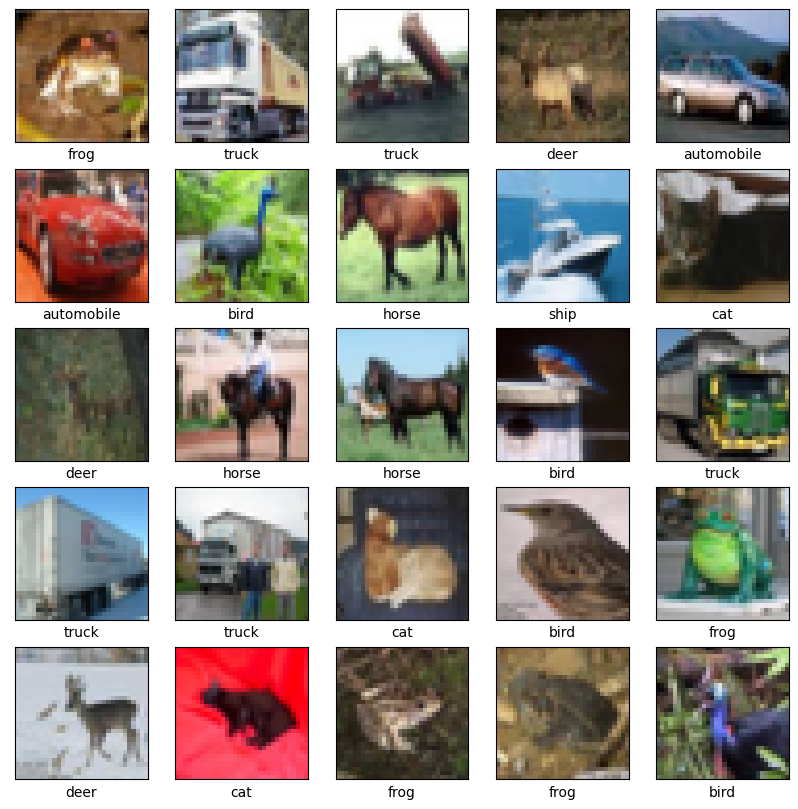

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [6]:
batch_size = 32
epochs = 50
data_activation = "linear"
signal_activation = "relu"
signal_conv_activation = "sigmoid"
signal_to_conv_activation = "sigmoid"
signal_encoding_dimensions = 8

conv_n = 5
conv_groups  = [2] * conv_n
conv_filters = [64] * conv_n
conv_kernels = [(3,3)] * conv_n

x_train = x_train - 0.5
x_test = x_test - 0.5

conv_reg = keras.regularizers.l2(0.0001)
dense_reg = keras.regularizers.l2(0.0001)

In [7]:
input_layer = keras.Input(shape=input_shape)

signal_bn = keras.layers.BatchNormalization(center=False)

# ---
#x = keras.layers.GaussianNoise(stddev=0.01)(input_layer)
x_avg = keras.layers.GlobalAveragePooling2D(keepdims=True)(input_layer)
x = input_layer - x_avg
x = keras.layers.Conv2D(filters=32,
                        padding="same",
                        strides=(2, 2),
                        use_bias=False,
                        kernel_size=(7, 7),
                        activation="relu",
                        kernel_regularizer=conv_reg)(x)
f_x = x
s = None

for i in range(conv_n):
    groups = conv_groups[i]
    filters = conv_filters[i]
    kernels = conv_kernels[i]
    
    x = keras.layers.Conv2D(filters=filters,
                            padding="same",
                            strides=(1, 1),
                            use_bias=False,
                            groups=groups,
                            kernel_size=kernels,
                            activation=data_activation,
                            kernel_regularizer=conv_reg)(f_x)
    g = keras.layers.Conv2D(filters=signal_encoding_dimensions*2,
                            padding="same",
                            strides=(1, 1),
                            use_bias=False,
                            kernel_size=(1, 1),
                            activation=signal_activation,
                            kernel_regularizer=conv_reg)(x)
    f = keras.layers.GlobalAveragePooling2D(keepdims=False)(g)
    s_tmp = keras.layers.Dense(signal_encoding_dimensions, 
                               use_bias=False, 
                               activation=signal_conv_activation, 
                               kernel_regularizer=dense_reg)(f)
    if s is None:
        s = signal_bn(s_tmp)
    else:
        s = signal_bn(s_tmp + s)
    
    y = keras.layers.Dense(filters,
                           use_bias=False, 
                           activation=signal_to_conv_activation, 
                           kernel_regularizer=dense_reg)(s)
    y_r = keras.layers.Reshape((1,1,-1))(y)
    f_x = keras.layers.Multiply()([x, y_r])
    if i % 2 == 1:
        f_x = keras.layers.MaxPooling2D(pool_size=(2, 2))(f_x)

# ---
x = keras.layers.Flatten()(f_x)
x = keras.layers.Dense(num_classes, 
                       use_bias=False, 
                       activation="linear", 
                       kernel_regularizer=dense_reg)(x)
output_layer = x

model_gate = \
    tf.keras.Model(
        inputs=input_layer,
        outputs=output_layer)

model_gate.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 global_average_pooling2d (Glob  (None, 1, 1, 3)     0           ['input_1[0][0]']                
 alAveragePooling2D)                                                                              
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 32, 32, 3)    0           ['input_1[0][0]',                
                                                                  'global_average_pooling2d[0][0]'
                                                                 ]                            

 global_average_pooling2d_4 (Gl  (None, 16)          0           ['conv2d_8[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_6 (Dense)                (None, 8)            128         ['global_average_pooling2d_4[0][0
                                                                 ]']                              
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 8)           0           ['dense_6[0][0]',                
 mbda)                                                            'batch_normalization[2][0]']    
                                                                                                  
 dense_7 (Dense)                (None, 64)           512         ['batch_normalization[3][0]']    
          

In [ ]:
model_gate.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.01),
    optimizer="adam",
    metrics=["accuracy"])

history = \
    model_gate.fit(
        x=x_train,
        y=y_train_categorical,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test_categorical))

Epoch 1/50
1563/1563 [==============================] - 308s 195ms/step - loss: 1.6243 - accuracy: 0.4353 - val_loss: 1.5468 - val_accuracy: 0.4963
Epoch 2/50
1563/1563 [==============================] - 302s 193ms/step - loss: 1.2436 - accuracy: 0.5913 - val_loss: 1.4162 - val_accuracy: 0.5439
Epoch 3/50
1563/1563 [==============================] - 303s 194ms/step - loss: 1.1089 - accuracy: 0.6444 - val_loss: 1.3458 - val_accuracy: 0.5690
Epoch 4/50
1563/1563 [==============================] - 302s 193ms/step - loss: 1.0314 - accuracy: 0.6778 - val_loss: 1.2637 - val_accuracy: 0.6122
Epoch 5/50
1563/1563 [==============================] - 304s 195ms/step - loss: 0.9735 - accuracy: 0.7019 - val_loss: 1.2546 - val_accuracy: 0.6129
Epoch 6/50
1563/1563 [==============================] - 301s 193ms/step - loss: 0.9285 - accuracy: 0.7208 - val_loss: 1.2341 - val_accuracy: 0.6272
Epoch 7/50
1563/1563 [==============================] - 292s 187ms/step - loss: 0.8920 - accuracy: 0.7350 - val_

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([-0.1, 2.5])
plt.grid(True)
plt.legend(loc="upper right")
plt.show()